# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn .pipeline import Pipeline
from sklearn.metrics import roc_auc_score
# magic word for producing visualizations in notebook
%matplotlib inline

# Loading the data

In [2]:
train_data=pd.read_csv('../capstone_data/Udacity_MAILOUT_052018_TRAIN.csv',low_memory=False)

In [3]:
test_data=pd.read_csv('../capstone_data/Udacity_MAILOUT_052018_TEST.csv',low_memory=False)

In [4]:
train_data.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


# Preprocessing Data

In [5]:
def Attribute_Unknown_Dict(path,df):
    '''
    Purpose: Map all the attributes to their unknown values in a dictionary
    
    Input: PATH TO DIAS Attributes - Values 2017.xlsx file, in str format
    
    Output:
    new_dict:Dictionary with attributes as key and the unknown meaning values in a list
    '''
    #reading the xlsx file and storing it in a dataframe
    attributes=pd.read_excel(path,skiprows=1)
    
    #formatting
    attributes=attributes.drop(['Unnamed: 0'],axis=1,inplace=False)
    
    #Droping all the rows with nan values. Since, all the first values refer to the unknown meaning category\
    #Only keeping the first row for each attribute works
    attributes=attributes.dropna()
    
    new_dict={}
    for i in range(attributes.shape[0]):
        #checking if it corresponds to the unknown value
        if ('unknown' in attributes['Meaning'].iloc[i].split()) or(attributes['Meaning'].iloc[i] == 'no transaction known'):
            new_list=[]
            if type(attributes['Value'].iloc[i])==int:
                new_list.append(attributes['Value'].iloc[i])
            else:
                for j in attributes['Value'].iloc[i].split(','):
                    new_list.append(int(j))

            new_dict[attributes['Attribute'].iloc[i]]=new_list
    
    #These columns are not present in  the actual dataset
    new_dict.pop('BIP_FLAG')
    new_dict.pop('GEOSCORE_KLS7')
    new_dict.pop('HAUSHALTSSTRUKTUR')
    new_dict.pop('SOHO_FLAG')
    new_dict.pop('WACHSTUMSGEBIET_NB')
    
    
    #Removing name '_RZ' from the end of each column name
    for i in new_dict:
        if i not in df.columns:
            new_dict[i[:-3]]=new_dict.pop(i)
    
    #removing the last key_value pair
    new_dict.pop('')
    
    
    return new_dict

In [6]:
def Map_unknown_to_NAN(df,attribute_dict):
    '''
    Replace the unknown values with NAN values in the df
    ARGS:
    df: Dataframe on which the mapping takes place like azdias
    attribute_dict: Dict with attribute as keys and values which are to replaced with NAN
    
    Output:
    df: transformed df with more null values
    
    '''
    #Replacing 
    for key,val in attribute_dict.items():
        for j in val:
            df[key]=df[key].replace(j,np.nan)
                
    return df

In [7]:
def cat_to_num(df):
    '''
    converting columns which are categorical to numerical and droping other categorical columns
    INput: 
    df: DataFrame to be processed
    
    Output:
    df: After droping and converting categorical columns
    
    '''
    
    #converting CAMEO_INTL_2015 AND CAMEO_DEUB_2015 into numerical values
    intl=[]
    deug=[]
    for i in range(len(df['CAMEO_INTL_2015'])):
        if type(df['CAMEO_INTL_2015'].iloc[i])==str and df['CAMEO_INTL_2015'].iloc[i][0]=='X':
            intl.append(np.nan)
        else:
            intl.append(float(df['CAMEO_INTL_2015'].iloc[i]))
        if type(df['CAMEO_INTL_2015'].iloc[i])==str and df['CAMEO_DEUG_2015'].iloc[i][0]=='X':
            deug.append(np.nan)
        else:
            deug.append(float(df['CAMEO_DEUG_2015'].iloc[i]))
    
    #droping the original columns
    df=df.drop(['CAMEO_INTL_2015','CAMEO_DEUG_2015'],axis=1,inplace=False)
    #Adding new columns
    df['CAMEO_INTL_2015']=intl
    df['CAMEO_DEUG_2015']=deug
    
    #droping 'LNR' AND 'VERDICHTUNGSRAUM' columns
    #droping the 'LP_FAMILIE_GROB' column because it very similar 'LP_FAMILIE_FEIN'

    df=df.drop(['LNR','VERDICHTUNGSRAUM','LP_FAMILIE_GROB'],axis=1,inplace=False)
    
    return df

In [8]:
def mixed_categories(df):
    '''
    Spliting mixed attributes into individua;
    Input:
    df: DataFrame to be processed
    
    Output:
    df
    '''
    
    df['WEALTH']=df['CAMEO_INTL_2015'].apply(lambda x:x/10)
    df['LIFE_CYCLE']=df['CAMEO_INTL_2015'].apply(lambda x:x%10)
    
    mainstream=[1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0]
    avantgarde=[2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]
    
    main=df['PRAEGENDE_JUGENDJAHRE'].isin([1.0, 3.0, 5.0, 8.0, 10.0, 12.0, 14.0])
    avar=df['PRAEGENDE_JUGENDJAHRE'].isin([2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0])
    
    df.loc[main,'MOVEMENT']=1.0
    df.loc[avar,'MOVEMENT']=2.0
    
    df=df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE'],axis=1,inplace=False)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O':1.0, 'W':2.0})
    
    new_df=pd.get_dummies(df,columns=['CAMEO_DEU_2015'])
    
    new_df=new_df.drop(['CAMEO_DEU_2015_XX'],axis=1,inplace=False)
    
    return new_df

In [9]:
def impute(df):
    '''
    Replacing all the null values with mean of the column
    
    '''
    
    fill_mean=lambda col:col.fillna(col.mean())
    df=df.apply(fill_mean,axis=0)
    
    return df

# Cleaning Training data

In [10]:
#Removing RESPONSE column from Training_data and storing it in train_labels
train_labels=train_data['RESPONSE']
train_data=train_data.drop(['RESPONSE'],axis=1,inplace=False)

In [11]:
#Implementing cleaning functions (same as preprocessing)
attribute_dict=Attribute_Unknown_Dict('../capstone_data/DIAS Attributes - Values 2017.xlsx',train_data)
train_data=Map_unknown_to_NAN(train_data,attribute_dict)

In [12]:
#Listing the columns with more than 50% of null values and droping it from training_df
drop_cols=list(train_data.isnull().sum(axis=0)[train_data.isnull().sum(axis=0)>0.50*(train_data.shape[0])]\
                    .reset_index()['index'])

In [13]:
#Implementing cleaning functions (same as preprocessing)
train_data=train_data.drop(columns=drop_cols,axis=1,inplace=False)
train_data=cat_to_num(train_data)
train_data=mixed_categories(train_data)
train_data=impute(train_data)

In [14]:
train_data.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.0,1.0,8.0,8.0,15.0,0.000000,0.0,1.0,13.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,4.0,13.0,13.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,9.0,7.0,0.0,0.049574,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,6.0,6.0,4.0,0.000000,0.0,2.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,9.0,9.0,53.0,0.000000,0.0,1.0,44.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Cleaning Testing data

In [15]:
#Storing the LNR column for submission on Kaggle
test_lnr=test_data['LNR']

In [16]:
test_data=Map_unknown_to_NAN(test_data,attribute_dict)

In [17]:
#Droping the same columns from testing data 
test_data=test_data.drop(columns=drop_cols,axis=1,inplace=False)

In [18]:
#Implementing cleaning functions (same as preprocessing)
test_data=cat_to_num(test_data)
test_data=mixed_categories(test_data)
test_data=impute(test_data)

In [19]:
test_data.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
0,2.000000,1.0,7.000000,6.0,2.0,0.0,0.0,2.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.651514,1.0,12.433248,0.0,20.0,0.0,0.0,1.0,21.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.000000,9.0,16.000000,11.0,2.0,0.0,0.0,4.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,1.651514,7.0,12.433248,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,1.0,21.000000,13.0,1.0,0.0,0.0,4.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#Checking that test and train data have same columns 
sum(train_data.columns==test_data.columns)

367

# Supervised Model

Text(0, 0.5, 'Proportion')

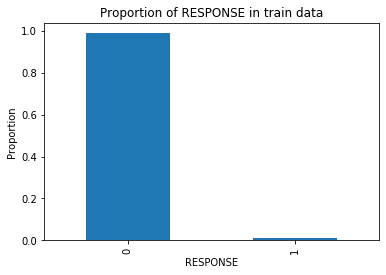

In [26]:
#Checking total proportion of positive response from training data
(train_labels.value_counts()/train_labels.shape[0]).plot(kind='bar')
plt.title('Proportion of RESPONSE in train data')
plt.xlabel('RESPONSE')
plt.ylabel('Proportion')

Since, only 1.2% of the total responses are customers, the TRAIN-TEST split of the training data should maintain this ratio across all folds. To do this, we can use StratifiedKFold which can preserve the proportions of all categories in each fold of the split.

In [27]:
#Spliting data into 7 folds
from sklearn.model_selection import StratifiedKFold
SF=StratifiedKFold(n_splits=7)
SF.get_n_splits(train_data,train_labels)

7

Since, this is a regression problem, initially, we can start with GradientBoosting, AdaBoosting, XGBoost and MLP Regressor.

In [28]:
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [29]:
#We can define pipelines for each model
pipeline1=Pipeline([('scaler',StandardScaler()),
                   ('clf',GradientBoostingRegressor())])
pipeline2=Pipeline([('scaler',StandardScaler()),
                   ('clf',AdaBoostRegressor())])
pipeline3=Pipeline([('scaler',StandardScaler()),
                   ('clf',XGBRegressor())])
pipeline4=Pipeline([('scaler',StandardScaler()),
                   ('clf',MLPRegressor())])

In [30]:
def predict_score(pipeline,column_name):
    '''
    To predict the predict scores of the pipeline
    Input: 
    pipeline : model to fit 
    column_name : model name in str
    '''
    scores=[]

    for train,test in SF.split(train_data,train_labels):

        pipeline.fit(train_data.iloc[train],train_labels.iloc[train])

        y_pred=pipeline.predict(train_data.iloc[test])

        score=roc_auc_score(train_labels.iloc[test],y_pred)

        scores.append(score)

        print(score)
    
    df=pd.DataFrame(scores,columns=[column_name])
    return df

In [31]:
 df1=predict_score(pipeline1,'Gradient')

0.7094399538106235
0.7771655611314662
0.7399677021653441
0.7844534513151383
0.7704239356020806
0.7160404310561919
0.769512152762702


In [32]:
df2=predict_score(pipeline2,'AdaBoostRegressor')

0.7270789560506348
0.7351349650106791
0.7328265814652104
0.7799108189546626
0.7840073289972995
0.7137729139711182
0.7672652593370904


In [33]:
df3=predict_score(pipeline3,'XGBRegressor')

0.5713905867439962
0.5903525412839259
0.6008894927850805
0.6545949513281638
0.597758316762042
0.6106546166604434
0.626901718493561


In [34]:
df4=predict_score(pipeline4,'MLPRegressor')

0.5410820642831096
0.5073983312785427
0.5779760457726302
0.5646714542502106
0.5488845856598269
0.5555015239798887
0.5263646349829366


In [35]:
#concatinating all the scores in a dataframe for each model
scores=pd.concat([df1,df2,df3,df4],axis=1)

In [36]:
scores.describe()

,Gradient,AdaBoostRegressor,XGBRegressor,MLPRegressor
count,7.000000,7.000000,7.000000,7.000000
mean,0.752429,0.748571,0.607506,0.545983
std,0.030497,0.027954,0.026897,0.023698
min,0.709440,0.713773,0.571391,0.507398
25%,0.728004,0.729953,0.594055,0.533723
50%,0.769512,0.735135,0.600889,0.548885
75%,0.773795,0.773588,0.618778,0.560086
max,0.784453,0.784007,0.654595,0.577976


# GridSearch on Gradient Boosting

In [37]:
pipeline1.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                             init=None, learning_rate=0.1, loss='ls', max_depth=3,
                             max_features=None, max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators=100,
                             n_iter_no_change=None, presort='deprecated',
                             random_state=None, subsample=1.0, tol=0.0001,
                             validation_fraction=0.1, verbose=0, warm_start=False))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                   

In [38]:
sk=StratifiedKFold(n_splits=2,shuffle=True)

In [39]:
parameters_1={'clf__learning_rate':[0.001,0.01,0.1,1],
             'clf__n_estimators' : [50,100,200,300],
             'clf__max_depth':[3,5,7]}

In [40]:
cv1=GridSearchCV(pipeline1,param_grid=parameters_1,scoring='roc_auc',cv=sk,return_train_score=True,n_jobs=-1)
cv1.fit(train_data,train_labels)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  ccp_alpha=0.0,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                    

In [41]:
cv1.best_params_

{'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100}

In [42]:
cv1.best_score_

0.7620141710628208

# GridSearch on AdaBoost

In [43]:
pipeline2.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                     n_estimators=50, random_state=None))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                   n_estimators=50, random_state=None),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'clf__base_estimator': None,
 'clf__learning_rate': 1.0,
 'clf__loss': 'linear',
 'clf__n_estimators': 50,
 'clf__random_state': None}

In [46]:
parameters_2={'clf__learning_rate':[0.001,0.01,0.1,1],
             'clf__n_estimators' : [50,100,200,300],
             }

In [47]:
cv2=GridSearchCV(pipeline2,param_grid=parameters_2,scoring='roc_auc',cv=sk,return_train_score=True,n_jobs=-1)
cv2.fit(train_data,train_labels)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        AdaBoostRegressor(base_estimator=None,
                                                          learning_rate=1.0,
                                                          loss='linear',
                                                          n_estimators=50,
                                                          random_state=None))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'clf__learning_rate': [0.001, 0.01, 0.1, 1

In [48]:
cv2.best_params_

{'clf__learning_rate': 0.001, 'clf__n_estimators': 100}

In [49]:
cv2.best_score_

0.7663046078547772

# GridSearch on XGBoost

In [50]:
pipeline3.get_params()

{'memory': None,
 'steps': [('scaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('clf',
   XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=100, n_jobs=0, num_parallel_tree=1,
                objective='reg:squarederror', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
                validate_parameters=1, verbosity=None))],
 'verbose': False,
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'clf': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
    

In [51]:
parameters_3={'clf__learning_rate':[0.001,0.01,0.3,1],'clf__gamma':[0.1,0,1]}

In [52]:
cv3=GridSearchCV(pipeline3,param_grid=parameters_3,scoring='roc_auc',cv=sk,return_train_score=True,n_jobs=-1)
cv3.fit(train_data,train_labels)

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     gamma=0, gpu_id=-1,
                                                     importance_type='gain',
                               

In [53]:
cv3.best_params_

{'clf__gamma': 0.1, 'clf__learning_rate': 0.01}

In [54]:
cv3.best_score_

0.7650205380290225

# Final Models

After gridsearch on all the three models, final model for each boosting type was created and tested on Kaggle. Currently, AdaBoosting model produces a 79.99% accuracy on the Kaggle submission.

In [77]:
gb=GradientBoostingRegressor(learning_rate=0.01,max_depth=3,n_estimators=100)
ada=AdaBoostRegressor(learning_rate=0.001,n_estimators=200)
xgb=XGBRegressor(learning_rate=0.01,gamma=0)

# Submission on Kaggle

In [78]:
def submission(model,name):
    '''
    Function to generate submission csv file
    Input: model after GridSearch
    name: name of the csv file
    
    Output: None
    Submission file will be saved in a particular location
    '''
    pipeline=Pipeline([('scaler',StandardScaler()),
                   ('clf',model)])
    
    pipeline.fit(train_data,train_labels)
    
    y_pred=pipeline.predict(test_data)
    
    name ='../capstone_data/' + name +'.csv'
    f=open(name,'w')
    f.write('LNR')
    f.write(',')
    f.write('RESPONSE')
    f.write('\n')

    for i in range(test_lnr.shape[0]):
        f.write(str(test_lnr.iloc[i]))
        f.write(',')
        f.write(str(y_pred[i]))
        f.write('\n')
    f.close()
    

In [81]:
submission(gb,'Submission_gb')

In [87]:
t=gb.feature_importances_
indices = np.argsort(t)[::-1]
columns_gb = train_data.columns.values[indices[:10]]

In [89]:
print(columns_gb)

['D19_SOZIALES' 'ANZ_KINDER' 'EINGEZOGENAM_HH_JAHR' 'SOHO_KZ'
 'D19_KONSUMTYP' 'KBA05_SEG2' 'VHA' 'KBA13_KRSSEG_KLEIN' 'KBA05_KW1'
 'D19_BUCH_CD']


In [83]:
submission(ada,'Submission_ada')

In [90]:
t=ada.feature_importances_
indices = np.argsort(t)[::-1]
columns_ada = train_data.columns.values[indices[:10]]
print(columns_ada)

['D19_SOZIALES' 'D19_KONSUMTYP' 'ANZ_KINDER' 'EINGEZOGENAM_HH_JAHR'
 'AKT_DAT_KL' 'D19_KONSUMTYP_MAX' 'SOHO_KZ' 'EXTSEL992' 'MIN_GEBAEUDEJAHR'
 'KBA05_SEG2']


In [91]:
submission(xgb,'Submission_xgb')
t=xgb.feature_importances_
indices = np.argsort(t)[::-1]
columns_xgb = train_data.columns.values[indices[:10]]
print(columns_xgb)

['KBA13_SEG_SPORTWAGEN' 'SEMIO_RAT' 'SEMIO_KRIT' 'KBA05_SEG6'
 'KBA13_KMH_0_140' 'KBA05_CCM1' 'CAMEO_DEU_2015_7B' 'KBA05_ANTG3'
 'SEMIO_TRADV' 'KBA05_SEG3']


In [96]:
feat_imp=pd.DataFrame(columns_ada,columns=['AdaBoost'])

In [98]:
feat_imp['GradientBoost']=columns_gb
feat_imp['XgBoost']=columns_xgb

In [99]:
feat_imp

,AdaBoost,GradientBoost,XgBoost
0,D19_SOZIALES,D19_SOZIALES,KBA13_SEG_SPORTWAGEN
1,D19_KONSUMTYP,ANZ_KINDER,SEMIO_RAT
2,ANZ_KINDER,EINGEZOGENAM_HH_JAHR,SEMIO_KRIT
3,EINGEZOGENAM_HH_JAHR,SOHO_KZ,KBA05_SEG6
4,AKT_DAT_KL,D19_KONSUMTYP,KBA13_KMH_0_140
5,D19_KONSUMTYP_MAX,KBA05_SEG2,KBA05_CCM1
6,SOHO_KZ,VHA,CAMEO_DEU_2015_7B
7,EXTSEL992,KBA13_KRSSEG_KLEIN,KBA05_ANTG3
8,MIN_GEBAEUDEJAHR,KBA05_KW1,SEMIO_TRADV
9,KBA05_SEG2,D19_BUCH_CD,KBA05_SEG3


In [115]:
final_score=pd.DataFrame(np.array(cv1.best_score_).reshape(1,1),columns=['AdaBoost'])
final_score['GradientBoost']=np.array(cv2.best_score_).reshape(1,1)
final_score['XGBoost']=np.array(cv3.best_score_).reshape(1,1)

In [116]:
final_score

,AdaBoost,GradientBoost,XGBoost
0,0.762014,0.766305,0.765021
